# DNN Classification

In [93]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from labm8 import fs
from labm8 import viz

from keras.models import Sequential
from keras.layers import Input, Dropout, Embedding, merge, LSTM, Dense
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import percentileofscore
from scipy.stats.mstats import gmean

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

import clgen
from clgen import clutil
from clgen.atomizer import CharacterAtomizer, GreedyAtomizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
seed = 7
np.random.seed(seed)

Methods for wrangling data:

In [103]:
def get_2(D):
    """ return np array of shape (len(D), nb_features)"""
    return np.array([
        D["transfer"].values,
        D["wgsize"].values,
    ]).T

def get_4(D):
    """ return np array of shape (len(D), nb_features)"""
    return np.array([
        (D["transfer"].values / (D["comp"].values + D["mem"].values)),  # F1
        (D["coalesced"].values / D["mem"].values),  # F2
        ((D["localmem"].values / D["mem"].values) * D["wgsize"].values),  # F3
        (D["comp"].values / D["mem"].values),  # F4
    ]).T
    
def get_11(D):
    """ return np array of shape (len(D), nb_features)"""
    return np.array([
        D["comp"].values,
        D["rational"].values,
        D["mem"].values,
        D["localmem"].values,
        D["coalesced"].values,
        D["transfer"].values,
        D["wgsize"].values,
        (D["transfer"].values / (D["comp"].values + D["mem"].values)),  # F1
        (D["coalesced"].values / D["mem"].values),  # F2
        ((D["localmem"].values / D["mem"].values) * D["wgsize"].values),  # F3
        (D["comp"].values / D["mem"].values),  # F4
    ]).T

def get_sequences(D, max_seq_len):
    """ return np array of shape (len(D), max_seq_len) """
    for row in D["seq"].values:
        assert(len(row) == max_seq_len)
    data = np.array(D["seq"].values)
    return np.vstack([np.expand_dims(x, axis=0) for x in data])

def get_labels(D):
    """ cpu/gpu to int, return np array of shape (len(D), 1) """
    return np.vstack([np.expand_dims(x, axis=0) for x in D["oracle_enc"]])

def get_train_validation_test_splits(D, split=(.6, .2, .2), seed=1):
    """ split dataframe into 3 frames for training, validation, and testing """
    if round(sum(split), 3) != 1.000:  # FIXME
        print(round(sum(split), 3))
    assert(round(sum(split), 3) == 1.000)
    train_split, validation_split, test_split = split
    
    num_synthetic = sum(D["synthetic"].values)
    
    np.random.seed(seed)
    train_msk = np.random.rand(len(D)) < train_split
    
    train = D[train_msk]
    other = D[~train_msk]
    
    test_msk = np.random.rand(len(other)) < split[2] / sum(split[1:])
    test = other[test_msk]
    validation = other[~test_msk]
 
    np.random.seed()  # re-seed RNG
    return train, validation, test

def get_train_validation_test_splits(D, split=(.6, .2, .2), seed=1):
    """ split dataframe into 3 frames for training, validation, and testing.
    synthetics are exclusively for training """
    # TODO: balance benchmark suites in splits
    # TODO: balance labels in splits
    if round(sum(split), 3) != 1.000:  # FIXME
        print(round(sum(split), 3))
    assert(round(sum(split), 3) == 1.0)
    train_split, validation_split, test_split = split
    
    num_synthetic = sum(D["synthetic"].values)
    num_benchmarks = len(D) - num_synthetic
    
    np.random.seed(seed)
    
    if num_benchmarks:
        train_msk = np.logical_or(np.random.rand(len(D)) < train_split, D["synthetic"])
    else:
        train_msk = np.random.rand(len(D)) < train_split
    
    train = D[train_msk]
    other = D[~train_msk]
    
    test_msk = np.random.rand(len(other)) < split[2] / sum(split[1:])
    test = other[test_msk]
    validation = other[~test_msk]

    np.random.seed()  # re-seed RNG
    return train, validation, test

def load_dataframe(platform, source="B", max_seq_len=1000, atomizer=CharacterAtomizer):
    """ load experimental results """
    def escape_suite_name(g):
        """format benchmark suite name for display"""
        c = g.split('-')
        if (c[0] == "amd" or c[0] == "npb" or c[0] == "nvidia" or c[0] == "shoc"):
            return c[0].upper()
        else:
            return c[0].capitalize()
    
    def get_benchmarks(platform):
        B = pd.read_csv(fs.path("classification/{platform}-benchmarks.csv".format(**vars())))
        B["source"] = [escape_suite_name(x) for x in B["benchmark"]]
        B["synthetic"] = [0] * len(B)
        return B

    def get_npb_benchmarks(platform):
        B = get_benchmarks(platform)
        msk = B["source"] == "NPB"
        return B[msk]
    
    def get_synthetics(platform):
        S = pd.read_csv(fs.path("classification/{platform}-clgen.csv".format(**vars())))
        S["source"] = ["CLgen"] * len(S)
        S["synthetic"] = [1] * len(S)
        return S
    
    if source == "B":
        dataframe = get_benchmarks(platform)
    elif source == "S":
        dataframe = get_synthetics(platform)
    elif source == "BS":
        dataframe = pd.concat((get_benchmarks(platform), get_synthetics(platform)))
    elif source == "N":
        dataframe = get_npb_benchmarks(platform)
    elif source == "NS":
        dataframe = pd.concat((get_npb_benchmarks(platform), get_synthetics(platform)))
    else:
        raise Exception

    print("num instances {} ({} synthetic, {} benchmarks)".format(
        len(dataframe),
        sum(dataframe["synthetic"].values),
        len(dataframe) - sum(dataframe["synthetic"].values)))
        
    dataframe["oracle_enc"] = [1 if x == "GPU" else 0 for x in dataframe["oracle"].values]

    # load source code:
    source_dir = fs.path("classification/kernels")
    srcs = []
    for row in dataframe["benchmark"].values:
        inpath = fs.path(source_dir, row + ".cl")
        with open(inpath) as infile:
            src = infile.read()
        if not src.startswith("__kernel void A"):
            print(fs.basename(inpath))
            raise Exception(src)
        srcs.append(src)
        
    print("unique kernels", len(set(srcs)))
    dataframe["src"] = srcs
    dataframe["src_len"] = [len(s) for s in srcs]
    
    # encode and pad sequences:
    atomizer = atomizer.from_text(''.join(dataframe["src"].values))
    
    seqs = [atomizer.atomize(seq) for seq in dataframe["src"].values]
    seq_length = min(max(len(s) for s in seqs), max_seq_len)
    pad_val = atomizer.vocab_size + 1
    dataframe["seq_len"] = [len(s) for s in seqs]
    dataframe["seq"] = list(pad_sequences(seqs, maxlen=seq_length, value=pad_val))
    print("vocab size", atomizer.vocab_size + 1)
    print("pad val", pad_val)
    print("padded seq length", seq_length)
    
    return dataframe, seq_length, atomizer

def get_training_data(seed, *args, split=(.6, .2, .2), **kwargs):
    train, validation, test = get_train_validation_test_splits(dataframe, seed=seed, split=split)

    x_train_2 = get_2(train)
    x_train_4 = get_4(train)
    x_train_11 = get_11(train)
    x_train_seq = get_sequences(train, seq_length)
    y_train = get_labels(train)
    
    x_val_2 = get_2(validation)
    x_val_4 = get_4(validation)
    x_val_11 = get_11(validation)
    x_val_seq = get_sequences(validation, seq_length)
    y_val = get_labels(validation)
    
    x_test_2 = get_2(test)
    x_test_4 = get_4(test)
    x_test_11 = get_11(test)
    x_test_seq = get_sequences(test, seq_length)
    y_test = get_labels(test)
    
    return (
        {"dataframe": train, "x_2": x_train_2, "x_4": x_train_4, "x_11": x_train_11, "x_seq": x_train_seq, "y": y_train},
        {"dataframe": validation, "x_2": x_val_2, "x_4": x_val_4, "x_11": x_val_11, "x_seq": x_val_seq, "y": y_val},
        {"dataframe": test, "x_2": x_test_2, "x_4": x_test_4, "x_11": x_test_11, "x_seq": x_test_seq, "y": y_test},
    )

Load dataset:

In [107]:
dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B",
    max_seq_len=1024, 
    atomizer=GreedyAtomizer
)

x_2 = get_2(dataframe)
x_4 = get_4(dataframe)
x_11 = get_11(dataframe)
x_seq = get_sequences(dataframe, seq_length)
y = get_labels(dataframe)

vocab_size = atomizer.vocab_size + 1  # +1 for pad value

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 129
pad val 129
padded seq length 1024


## Dataset exploration

Accuracy of Zero-R (GPU): 56.91%


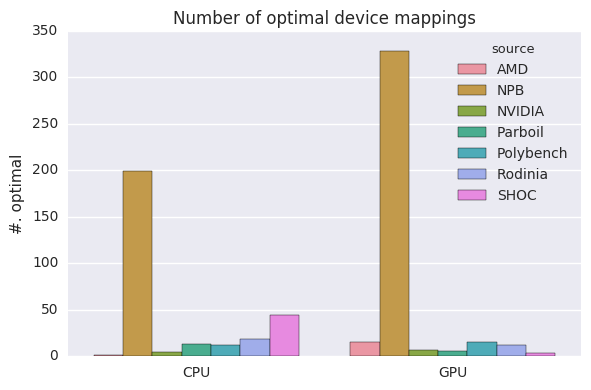

In [108]:
ax = sns.countplot(x="oracle_enc", data=dataframe, hue="source")
plt.title("Number of optimal device mappings")
plt.xticks([0, 1], ["CPU", "GPU"])
plt.xlabel("")
plt.ylabel("#. optimal")

num_oracle_gpu = sum(dataframe["oracle_enc"])
num_oracle_cpu = len(dataframe) - num_oracle_gpu
zero_r = "CPU" if num_oracle_cpu > num_oracle_gpu else "GPU"
acc_zero_r = max(num_oracle_cpu, num_oracle_gpu) / len(dataframe)

print("Accuracy of Zero-R ({zero_r}): {acc_zero_r:.2%}".format(**vars()))

viz.finalise(figsize=(6, 4))

min seq len 53
max seq len 24604
mean seq len 2650
25% percentile 290
50% percentile 538
60% percentile 724
75% percentile 1504
90% percentile 13449
padded seq len 1024
percentile of padded seq len 66.5%


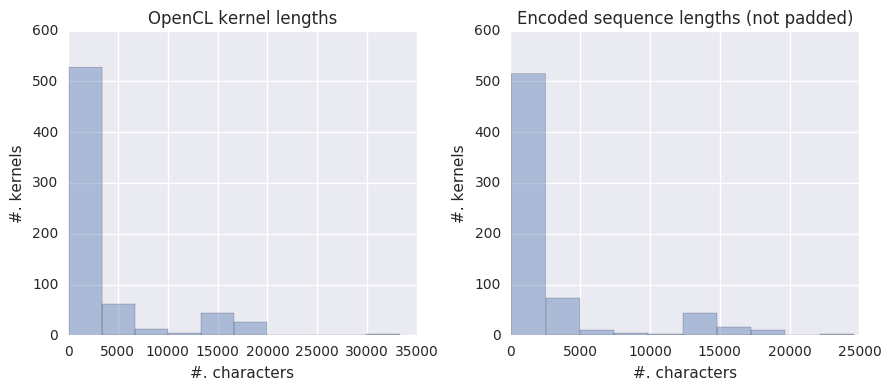

In [109]:
plt.subplot(1, 2, 1)
ax = sns.distplot(dataframe["src_len"], kde=None, bins=10)
plt.title("OpenCL kernel lengths")
plt.xlabel("#. characters")
plt.ylabel("#. kernels")

plt.subplot(1, 2, 2)
ax = sns.distplot(dataframe["seq_len"], kde=None, bins=10)
plt.title("Encoded sequence lengths (not padded)")
plt.xlabel("#. characters")
plt.ylabel("#. kernels")

print("min seq len", min(dataframe["seq_len"]))
print("max seq len", max(dataframe["seq_len"]))
print("mean seq len", int(round(np.mean(dataframe["seq_len"]))))
for p in [25, 50, 60, 75, 90]:
    print("{p}% percentile".format(p=p), int(np.percentile(dataframe["seq_len"], p)))
print("padded seq len", seq_length)
print("percentile of padded seq len {:.1f}%".format(
    percentileofscore(dataframe["seq_len"], seq_length, 'mean')))

viz.finalise(figsize=(9, 4))

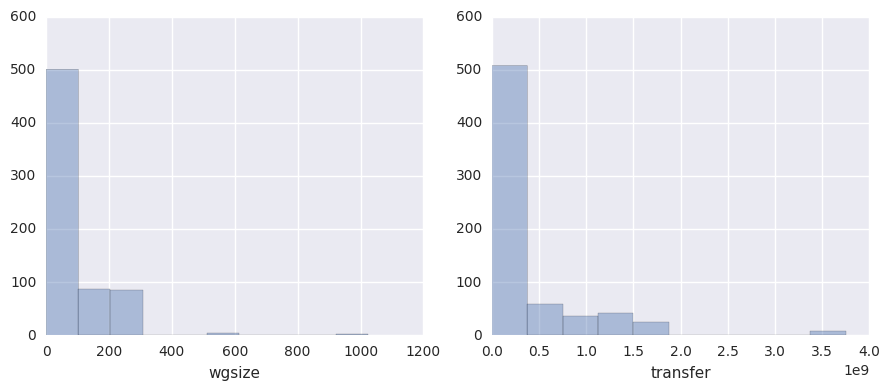

In [110]:
plt.subplot(1, 2, 1)
ax = sns.distplot(dataframe["wgsize"], kde=None, bins=10)
plt.subplot(1, 2, 2)
ax = sns.distplot(dataframe["transfer"], kde=None, bins=10)
viz.finalise(figsize=(9, 4))

## Source + dynamic props classification

In [111]:
def evaluate(create_model, train_fn, test_fn, seed=1, save_fn=None, split=(.6, .2, .2), n=5, quiet=False):
    """
    Arguments:
        create_model (function): Function with definition:
                create_model(seed, i) -> model
        train_fn (function): Function with definition:
                train_fn(seed, model, train_data, validation_data) -> {}
        save_fn (function): Function with definition:
                save_fn(seed, i, model) -> None
        test_fn (function): Function with definition:
                test_fn(seed, model, test_data) -> {}
        n (int): Number of repetitions
    
    Returns:
        list: list of length n, each element a pair of train_fn(), test_fn() return values
    """
    train_results = []
    test_results = []
    for i in range(n):
        j = i + 1
        # get training_data
        train, validation, test = get_training_data(seed=seed + i, i=i, n=n, split=split)
        # create model
        model = create_model(i=i, seed=seed + i)
        # train model
        start = time.time()
        train_result = train_fn(model=model, train=train, validation=validation, i=i, seed=seed + i) or {}
        elapsed = time.time() - start
        train_result["time"] = elapsed
        m = len(train["y"])
        #if elapsed > 3:
        if not quiet:
            print("[{j:2} of {n}] training on {m} instances took {elapsed:.2f}s".format(**vars()))
        train_results.append(train_result)
        # save model
        if save_fn is not None:
            save_fn(model=model, i=i, n=n, seed=seed + i)
        # make predictions
        start = time.time()
        predictions = test_fn(model=model, test=test, i=i, seed=seed + i)
        elapsed = time.time() - start
        test_result = analyze(predictions, test)
        test_result["time"] = elapsed
        accuracy = test_result["accuracy"]
        geo_speedup = test_result["speedup_geo"]
        m = len(test["y"])
        
        if not quiet:
            print("[{j:2} of {n}] accuracy on {m} test instances: {accuracy:.2%}, speedup {geo_speedup:.2}x (elapsed {elapsed:.2f}s)".format(**vars()))
        test_results.append(test_result)

        del model
    
    # accuracy
    a = np.array([x["accuracy"] for x in test_results])
    mean_acc = a.mean()
    std = a.std()
    
    a = np.array([x["speedup_geo"] for x in test_results])
    geo_speedup = gmean(a)
    std_speedup = a.std()
    
    # times
    a = np.array([x["time"] for x in train_results])
    mean_train_time = a.mean()
    std_train_time = a.std()
    
    a = np.array([x["time"] for x in test_results])
    mean_eval_time = a.mean()
    std_eval_time = a.std()
    
    if not quiet:
        print()
    print("avg training time {mean_train_time:.2}s, eval time {mean_eval_time:.2}s".format(**vars()))
    print("avg accuracy {mean_acc:.2%} (std: {std:.2%}), speedup {geo_speedup:.2}x (std: {std_speedup:.2%})".format(**vars()))
    return train_results, test_results

In [112]:
def analyze(predictions, test):
    frame = test["dataframe"]
    oracle = np.array(frame["oracle_enc"], dtype=np.bool)
    incorrect = np.logical_xor(predictions, oracle)
    correct = np.logical_not(incorrect)
    
    speedups = frame["speedup"][correct]
    penalties = frame["penalty"][incorrect]
    speedups = speedups.append(penalties)
    speedup_avg = speedups.mean()
    speedup_geo = gmean(speedups)
    
    accuracy = sum(correct) / len(test["dataframe"])
    
    confusion_matrix = np.zeros((2, 2), dtype="int32")
    confusion_matrix[0][0] = sum(np.logical_and(np.logical_not(predictions), np.logical_not(oracle)))
    confusion_matrix[0][1] = sum(np.logical_and(predictions, np.logical_not(oracle)))
    confusion_matrix[1][0] = sum(np.logical_and(np.logical_not(predictions), oracle))
    confusion_matrix[1][1] = sum(np.logical_and(predictions, oracle))
    
    assert(confusion_matrix.sum() == len(test["dataframe"]))
    assert(confusion_matrix[0][1] + confusion_matrix[1][1] == sum(predictions))
    assert(confusion_matrix[0][1] + confusion_matrix[1][0] == sum(incorrect))
    assert(confusion_matrix[0][0] + confusion_matrix[1][1] == sum(correct))
    
    return {
        "accuracy": accuracy,
        "confusion_matrix": confusion_matrix,
        "speedups": speedups,
        "speedup_min": min(speedups),
        "speedup_max": max(speedups),
        "speedup_avg": speedup_avg,
        "speedup_geo": speedup_geo,
    }

### CGO'13 model

In [10]:
def create_model(seed=seed, **kwargs):
    np.random.seed(seed)
    return DecisionTreeClassifier(random_state=seed, splitter="best", criterion="entropy")

def train_fn(model, train, validation, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_4"], train["y"])
    return {}
    
def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    return model.predict(test["x_4"])

results = evaluate(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10)

[ 1 of 10] training on 397 instances took 0.00s
[ 1 of 10] accuracy on 145 test instances: 83.45%, speedup 2.2x (elapsed 0.00s)
[ 2 of 10] training on 378 instances took 0.00s
[ 2 of 10] accuracy on 128 test instances: 81.25%, speedup 1.9x (elapsed 0.00s)
[ 3 of 10] training on 420 instances took 0.00s
[ 3 of 10] accuracy on 131 test instances: 74.81%, speedup 1.7x (elapsed 0.00s)
[ 4 of 10] training on 409 instances took 0.00s
[ 4 of 10] accuracy on 129 test instances: 85.27%, speedup 2.4x (elapsed 0.00s)
[ 5 of 10] training on 410 instances took 0.00s
[ 5 of 10] accuracy on 139 test instances: 82.73%, speedup 2.0x (elapsed 0.00s)
[ 6 of 10] training on 410 instances took 0.00s
[ 6 of 10] accuracy on 145 test instances: 77.24%, speedup 1.9x (elapsed 0.00s)
[ 7 of 10] training on 410 instances took 0.00s
[ 7 of 10] accuracy on 134 test instances: 77.61%, speedup 2.1x (elapsed 0.00s)
[ 8 of 10] training on 387 instances took 0.00s
[ 8 of 10] accuracy on 147 test instances: 82.99%, speed

### CGO'13 Model (only dynprops)

In [18]:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    return DecisionTreeClassifier(random_state=seed, splitter="best", criterion="entropy")

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_2"], train["y"])
    return {}
    
def test_fn(model, test, *args, seed=None, **kwargs):
    np.random.seed(seed)
    return model.predict(test["x_2"])

results = evaluate(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10)

[ 1 of 10] training on 397 instances took 0.00s
[ 1 of 10] accuracy on 145 test instances: 83.45%, speedup 2.4x (elapsed 0.00s)
[ 2 of 10] training on 378 instances took 0.00s
[ 2 of 10] accuracy on 128 test instances: 78.91%, speedup 1.9x (elapsed 0.00s)
[ 3 of 10] training on 420 instances took 0.00s
[ 3 of 10] accuracy on 131 test instances: 81.68%, speedup 2.1x (elapsed 0.00s)
[ 4 of 10] training on 409 instances took 0.00s
[ 4 of 10] accuracy on 129 test instances: 84.50%, speedup 2.7x (elapsed 0.00s)
[ 5 of 10] training on 410 instances took 0.00s
[ 5 of 10] accuracy on 139 test instances: 81.29%, speedup 2.1x (elapsed 0.00s)
[ 6 of 10] training on 410 instances took 0.00s
[ 6 of 10] accuracy on 145 test instances: 84.83%, speedup 2.3x (elapsed 0.00s)
[ 7 of 10] training on 410 instances took 0.00s
[ 7 of 10] accuracy on 134 test instances: 78.36%, speedup 2.2x (elapsed 0.00s)
[ 8 of 10] training on 387 instances took 0.00s
[ 8 of 10] accuracy on 147 test instances: 78.23%, speed

**Effect of split size on accuracy:**

In [20]:
%%capture
splits = [(x, (1-x)/2, (1-x)/2) for x in np.arange(0.05,.975,0.025)]
results = list(zip(
    splits, [evaluate(create_model, train_fn, test_fn, split=split, seed=204, n=10) for split in splits]))

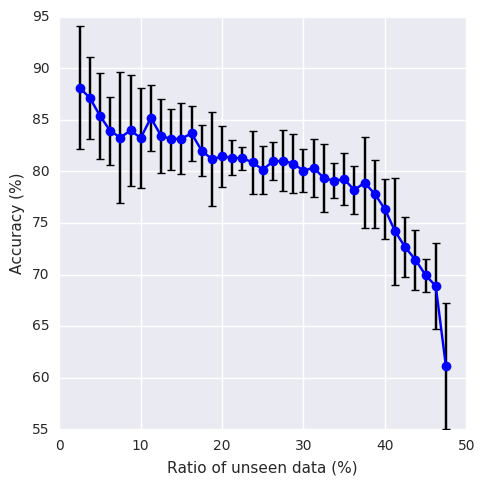

In [66]:
# TODO:
# y = [np.array([x["accuracy"] * 100 for x in r[1][1]]) for r in results]
# sns.tsplot(data=y)

x = [r[0][2] * 100 for r in results]
y = [np.array([x["accuracy"] * 100 for x in r[1][1]]).mean() for r in results]
err = [np.array([x["accuracy"] * 100 for x in r[1][1]]).std() for r in results]
plt.plot(x, y, color="b")
plt.errorbar(x, y, yerr=err, color="b", fmt='o', ecolor='k', capthick=1)

plt.xlabel("Ratio of unseen data (%)")
plt.ylabel("Accuracy (%)")

viz.finalise(figsize=(5, 5))

### Baseline model (only dynprops)

In [ ]:
# TODO: batch norm after merge, not before
# TODO: another layer of LSTM
# TODO: Dropout?
# TODO: activations: rely, sigmoid, softmax, tanh

def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)

    model = Sequential()
    model.add(BatchNormalization(input_shape=(2,), name="dynprop_norm"))
    model.add(Dense(16, init='normal', activation="relu"))
    model.add(Dropout(0.15))
    model.add(Dense(16, init='normal', activation="relu"))
    model.add(Dropout(0.15))
    model.add(Dense(16, init='normal', activation="relu"))
    model.add(Dropout(0.15))
    model.add(Dense(1, init='normal', activation='sigmoid', name="output"))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_2"].astype(np.int32), train["y"].astype(np.int32),
              nb_epoch=10,
              validation_data=(validation["x_2"].astype(np.int32), validation["y"].astype(np.int32)),
              verbose=0)
    return {}
    
def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    return np.array([x[0] > .5 for x in model.predict(test["x_2"].astype(np.int32), verbose=0)])

results = evaluate(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=205, n=10)

[ 1 of 10] training on 378 instances took 5.77s
[ 1 of 10] accuracy on 128 test instances: 53.12%, speedup 1.5x (elapsed 1.88s)
[ 2 of 10] training on 420 instances took 4.45s
[ 2 of 10] accuracy on 131 test instances: 55.73%, speedup 1.4x (elapsed 1.87s)
[ 3 of 10] training on 409 instances took 4.64s
[ 3 of 10] accuracy on 129 test instances: 58.91%, speedup 1.6x (elapsed 1.93s)
[ 4 of 10] training on 410 instances took 4.65s
[ 4 of 10] accuracy on 139 test instances: 58.99%, speedup 1.7x (elapsed 1.92s)
[ 5 of 10] training on 410 instances took 4.61s
[ 5 of 10] accuracy on 145 test instances: 60.00%, speedup 1.6x (elapsed 2.02s)


# model = create_model()
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Baseline model

In [16]:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)

    baseline = Sequential()
    baseline.add(BatchNormalization(input_shape=(4,), name="dynprop_norm"))
    baseline.add(Dense(4, input_dim=4, activation="relu"))
    baseline.add(Dense(2, activation="relu"))
    baseline.add(Dense(1, activation='sigmoid', name="output"))

    baseline.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
    return baseline

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_4"], train["y"],
              nb_epoch=10,
              validation_data=(validation["x_4"], validation["y"]),
              verbose=0)
    return {}
    
def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    return np.array([x[0] > .5 for x in model.predict(test["x_4"], verbose=0)])

results = evaluate(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10)

[ 1 of 10] training on 397 instances took 1.85s
[ 1 of 10] accuracy on 145 test instances: 61.38%, speedup 1.8x (elapsed 0.17s)
[ 2 of 10] training on 378 instances took 2.04s
[ 2 of 10] accuracy on 128 test instances: 53.12%, speedup 1.5x (elapsed 0.22s)
[ 3 of 10] training on 420 instances took 1.89s
[ 3 of 10] accuracy on 131 test instances: 51.91%, speedup 1.3x (elapsed 0.25s)
[ 4 of 10] training on 409 instances took 1.85s
[ 4 of 10] accuracy on 129 test instances: 52.71%, speedup 1.3x (elapsed 0.26s)
[ 5 of 10] training on 410 instances took 2.09s
[ 5 of 10] accuracy on 139 test instances: 58.27%, speedup 1.3x (elapsed 0.27s)


KeyboardInterrupt: 

In [ ]:
model = create_model()
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Baseline with only source

### Multi-input model

In [ ]:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)

    embedding_vector_length = 64 # 64

    # TODO: batch norm after merge, not before
    # TODO: another layer of LSTM
    # TODO: Dropout?
    # TODO: activations: rely, sigmoid, softmax, tanh

    dyn_inputs = Input(shape=(2,), name="dynprop_in")
    left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

    seq_inputs = Input(shape=(seq_length,), dtype="int32", name="seq_in")
    right = Embedding(output_dim=embedding_vector_length, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
    # right = LSTM(32, consume_less="mem", return_sequences=True)(right)
    # right = Dropout(.2)(right)
    right = LSTM(32, consume_less="mem")(right)
    right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

    aux_out = Dense(1, activation="sigmoid", name="aux_out")(right)

    x = merge([left, right], mode="concat")
    x = Dense(32, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    out = Dense(1, activation="sigmoid", name="out")(x)

    model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])
    model.compile(optimizer="adam", # adam
              loss={"out": "binary_crossentropy", "aux_out": "binary_crossentropy"},
              loss_weights={"out": 1., "aux_out": .2})
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    batch_size = 3
    model.fit({"dynprop_in": train["x_2"], "seq_in": train["x_seq"]},
          {"out": train["y"], "aux_out": train["y"]},
          nb_epoch=50, # 50,
          batch_size=batch_size, # 32
          validation_data=({"dynprop_in": validation["x_2"], "seq_in": validation["x_seq"]},
                           {"out": validation["y"], "aux_out": validation["y"]}),
          verbose=1,
          shuffle=True
    )
    return {}

def save_fn(model, seed, i, *args, **kwargs):
    outpath = "models/model-{i}-{seed}.h5".format(**vars())
    model.save(outpath)
    
def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    batch_size = 3
    predictions = model.predict({"dynprop_in": test["x_2"], "seq_in": test["x_seq"]},
                                {"out": test["y"], "aux_out": test["y"]},
                                batch_size=batch_size, verbose=0)
    return np.array([x[0] > .5 for x in predictions])

results = evaluate(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10)

Train on 397 samples, validate on 138 samples
Epoch 1/50
397/397 [==============================] - 230s - loss: 0.8246 - out_loss: 0.6895 - aux_out_loss: 0.6752 - val_loss: 0.8031 - val_out_loss: 0.6697 - val_aux_out_loss: 0.6673

In [ ]:
model = create_model()
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))